In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.20 GB, difference +0.20 GB
scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [4]:
#load data with leiden
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/bb2_bb3_leiden_1.4_sub_rec_log_norm_DGE_v1_annotation_95563x37733_240729_19h05.h5ad")

## Ultafine clustering

In [6]:
# using scanpy's Leiden clustering at various resolution
# using ultra-high values to cluster the doublets expecting there will not be a lot of them
# and they will cluster together in these small clusters

for i in [50, 60, 80, 100]:
    sc.tl.leiden(adata, flavor = "igraph", resolution = i, key_added = "leiden_%s" %i)
    print(i, len(adata.obs["leiden_%s" %i].unique()))


running Leiden clustering
    finished (0:00:04)
50 912
running Leiden clustering
    finished (0:00:04)
60 1130
running Leiden clustering
    finished (0:00:04)
80 1565
running Leiden clustering
    finished (0:00:04)
100 1962


In [7]:
obs = adata.obs.copy()

# add the results to obs

# adding percentile
for i in [3,5,10]:   
    adata.obs["top%dpct_dbtl_score"%i] = adata.obs["doublet_score"]>=adata.obs["doublet_score"].quantile(1.-float(i)/100.)

In [8]:
#Make a dataframe with per-cell metadata with cluster and doublet info
adata.obs[["doublet_score", "top10pct_dbtl_score"]]

doublet_score  top10pct_dbtl_score
1            0.195876                False
2            0.163418                False
3            0.220339                 True
4            0.229572                 True
6            0.079070                False
...               ...                  ...
111564       0.110588                False
111565       0.098039                False
111567       0.033248                False
111568       0.031289                False
111569       0.065744                False

[95563 rows x 2 columns]

In [9]:
# take doublet info from obs:
o = adata.obs[["top10pct_dbtl_score","doublet_score"]].astype(float).copy()
print(o.shape)

(95563, 2)


In [10]:
# choose cluster configuration

label = "leiden_100"

o[label] = adata.obs[label]

o.head(3)

top10pct_dbtl_score  doublet_score leiden_100
1                  0.0       0.195876          0
2                  0.0       0.163418          2
3                  1.0       0.220339          6

In [11]:
gb = o.groupby(label)
smr = gb.aggregate({"top10pct_dbtl_score":['count','sum'],
             "doublet_score":['mean']})

smr.columns = smr.columns.droplevel()
smr["dblt_fraction"] = smr["sum"]/smr["count"]

renamer = {"sum":"nr_cell_in_top10_pct_dblt","mean":"mean_dbt_score"}
smr.columns = [renamer[i] if i in renamer else i for i in smr.columns]

smr.head()

/var/folders/sv/fwsrf8xs57jd9rtwwfxmyxg80000gn/T/ipykernel_31051/4286711504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb = o.groupby(label)


count  nr_cell_in_top10_pct_dblt  mean_dbt_score  dblt_fraction
leiden_100                                                                 
0             120                       23.0        0.134468       0.191667
1              94                        4.0        0.103438       0.042553
2              31                        2.0        0.116210       0.064516
3              41                        3.0        0.114800       0.073171
4              33                        4.0        0.116605       0.121212

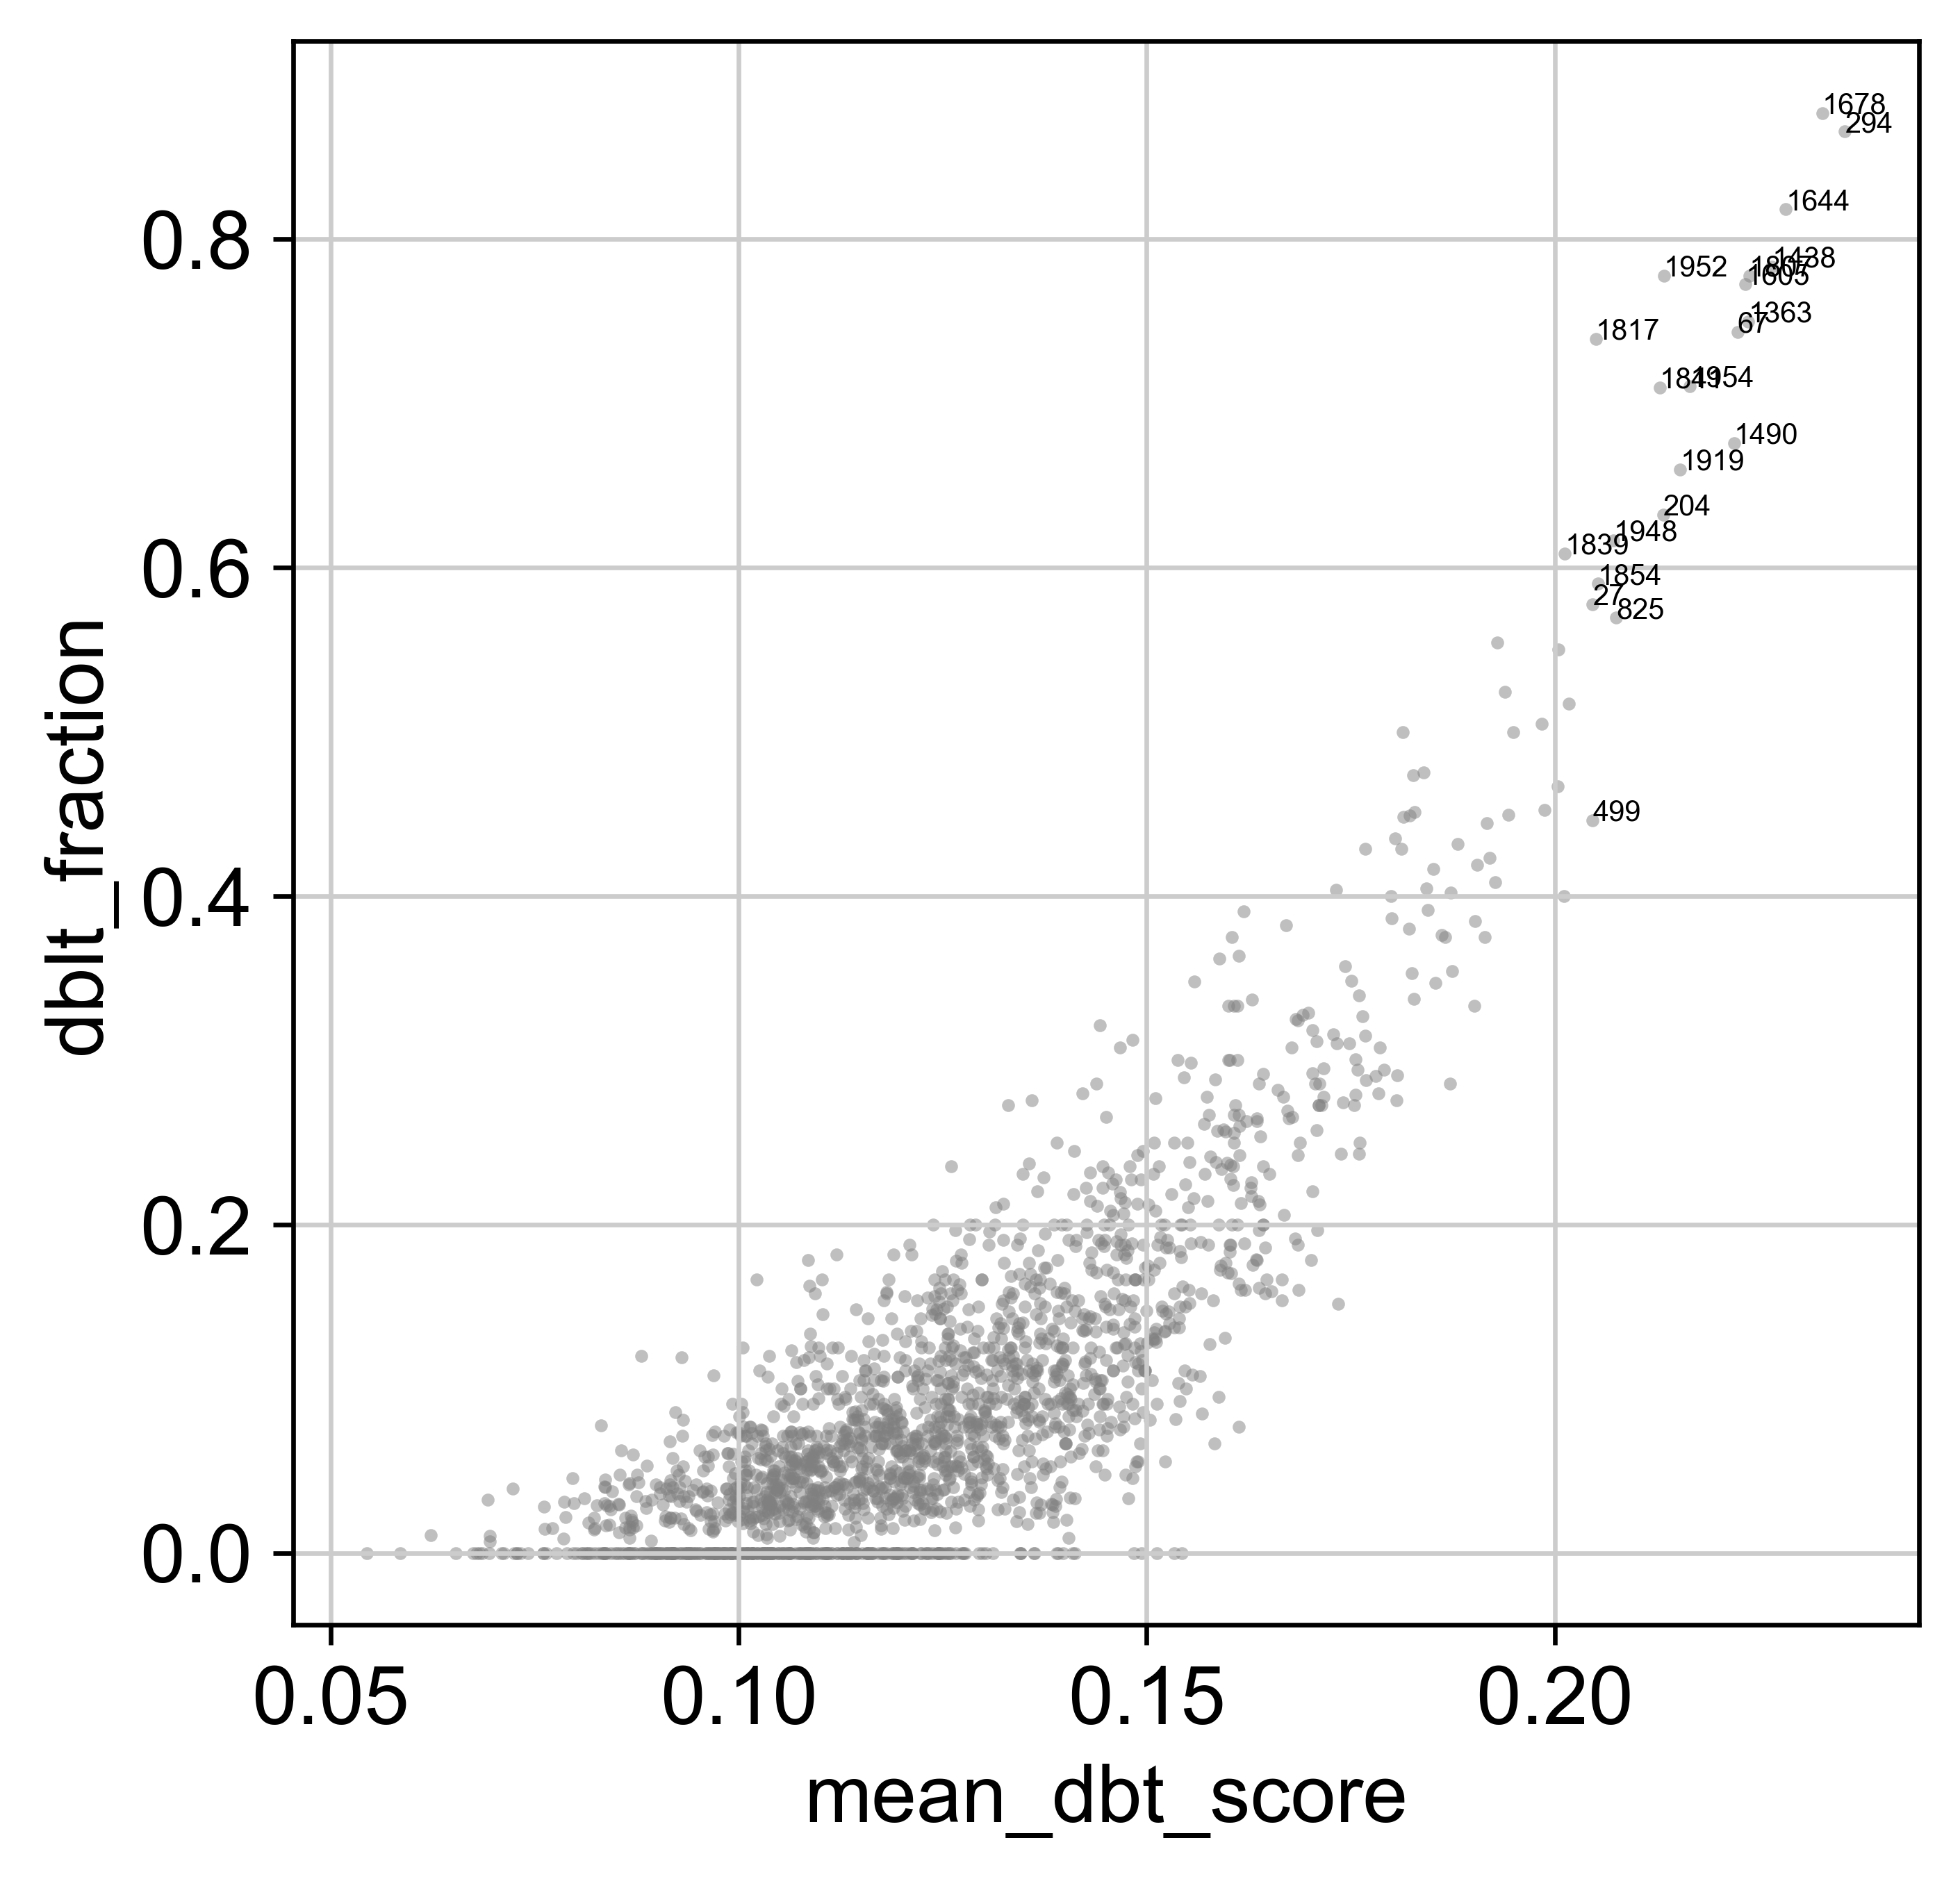

In [12]:
# Plot mean dblt score vs fraction potential dblt

fig, ax = plt.subplots(figsize=(5, 5))

lab1 = "mean_dbt_score"
lab2 = "dblt_fraction"

x = smr[lab1]
y = smr[lab2]

ax.set_xlabel(lab1)
ax.set_ylabel(lab2)

# print labels for the top n clusters with highest average dblt score
# and top n with highest fraction
upto = 20

thetop = list(set(list(x.sort_values(ascending=False)[:upto].index)+\
         list(y.sort_values(ascending=False)[:upto].index)))

for i,j,txt in zip(x,y,x.index):
    if txt in thetop:
        ax.text(i,j,txt, size = 5)

ax.scatter(x, y, lw=0, c = "0.5", alpha = 0.5, s = 5)
#plt.savefig('prec_pca_louv_60_doublets.png')

In [13]:
thetop

['1841',
 '1919',
 '1839',
 '1678',
 '1490',
 '1605',
 '1854',
 '1952',
 '1644',
 '1438',
 '1363',
 '499',
 '1948',
 '27',
 '825',
 '1817',
 '204',
 '67',
 '1954',
 '294',
 '1807']

the obs value 'leiden_100' has more than 103 categories. Uniform 'grey' color will be used for all categories.


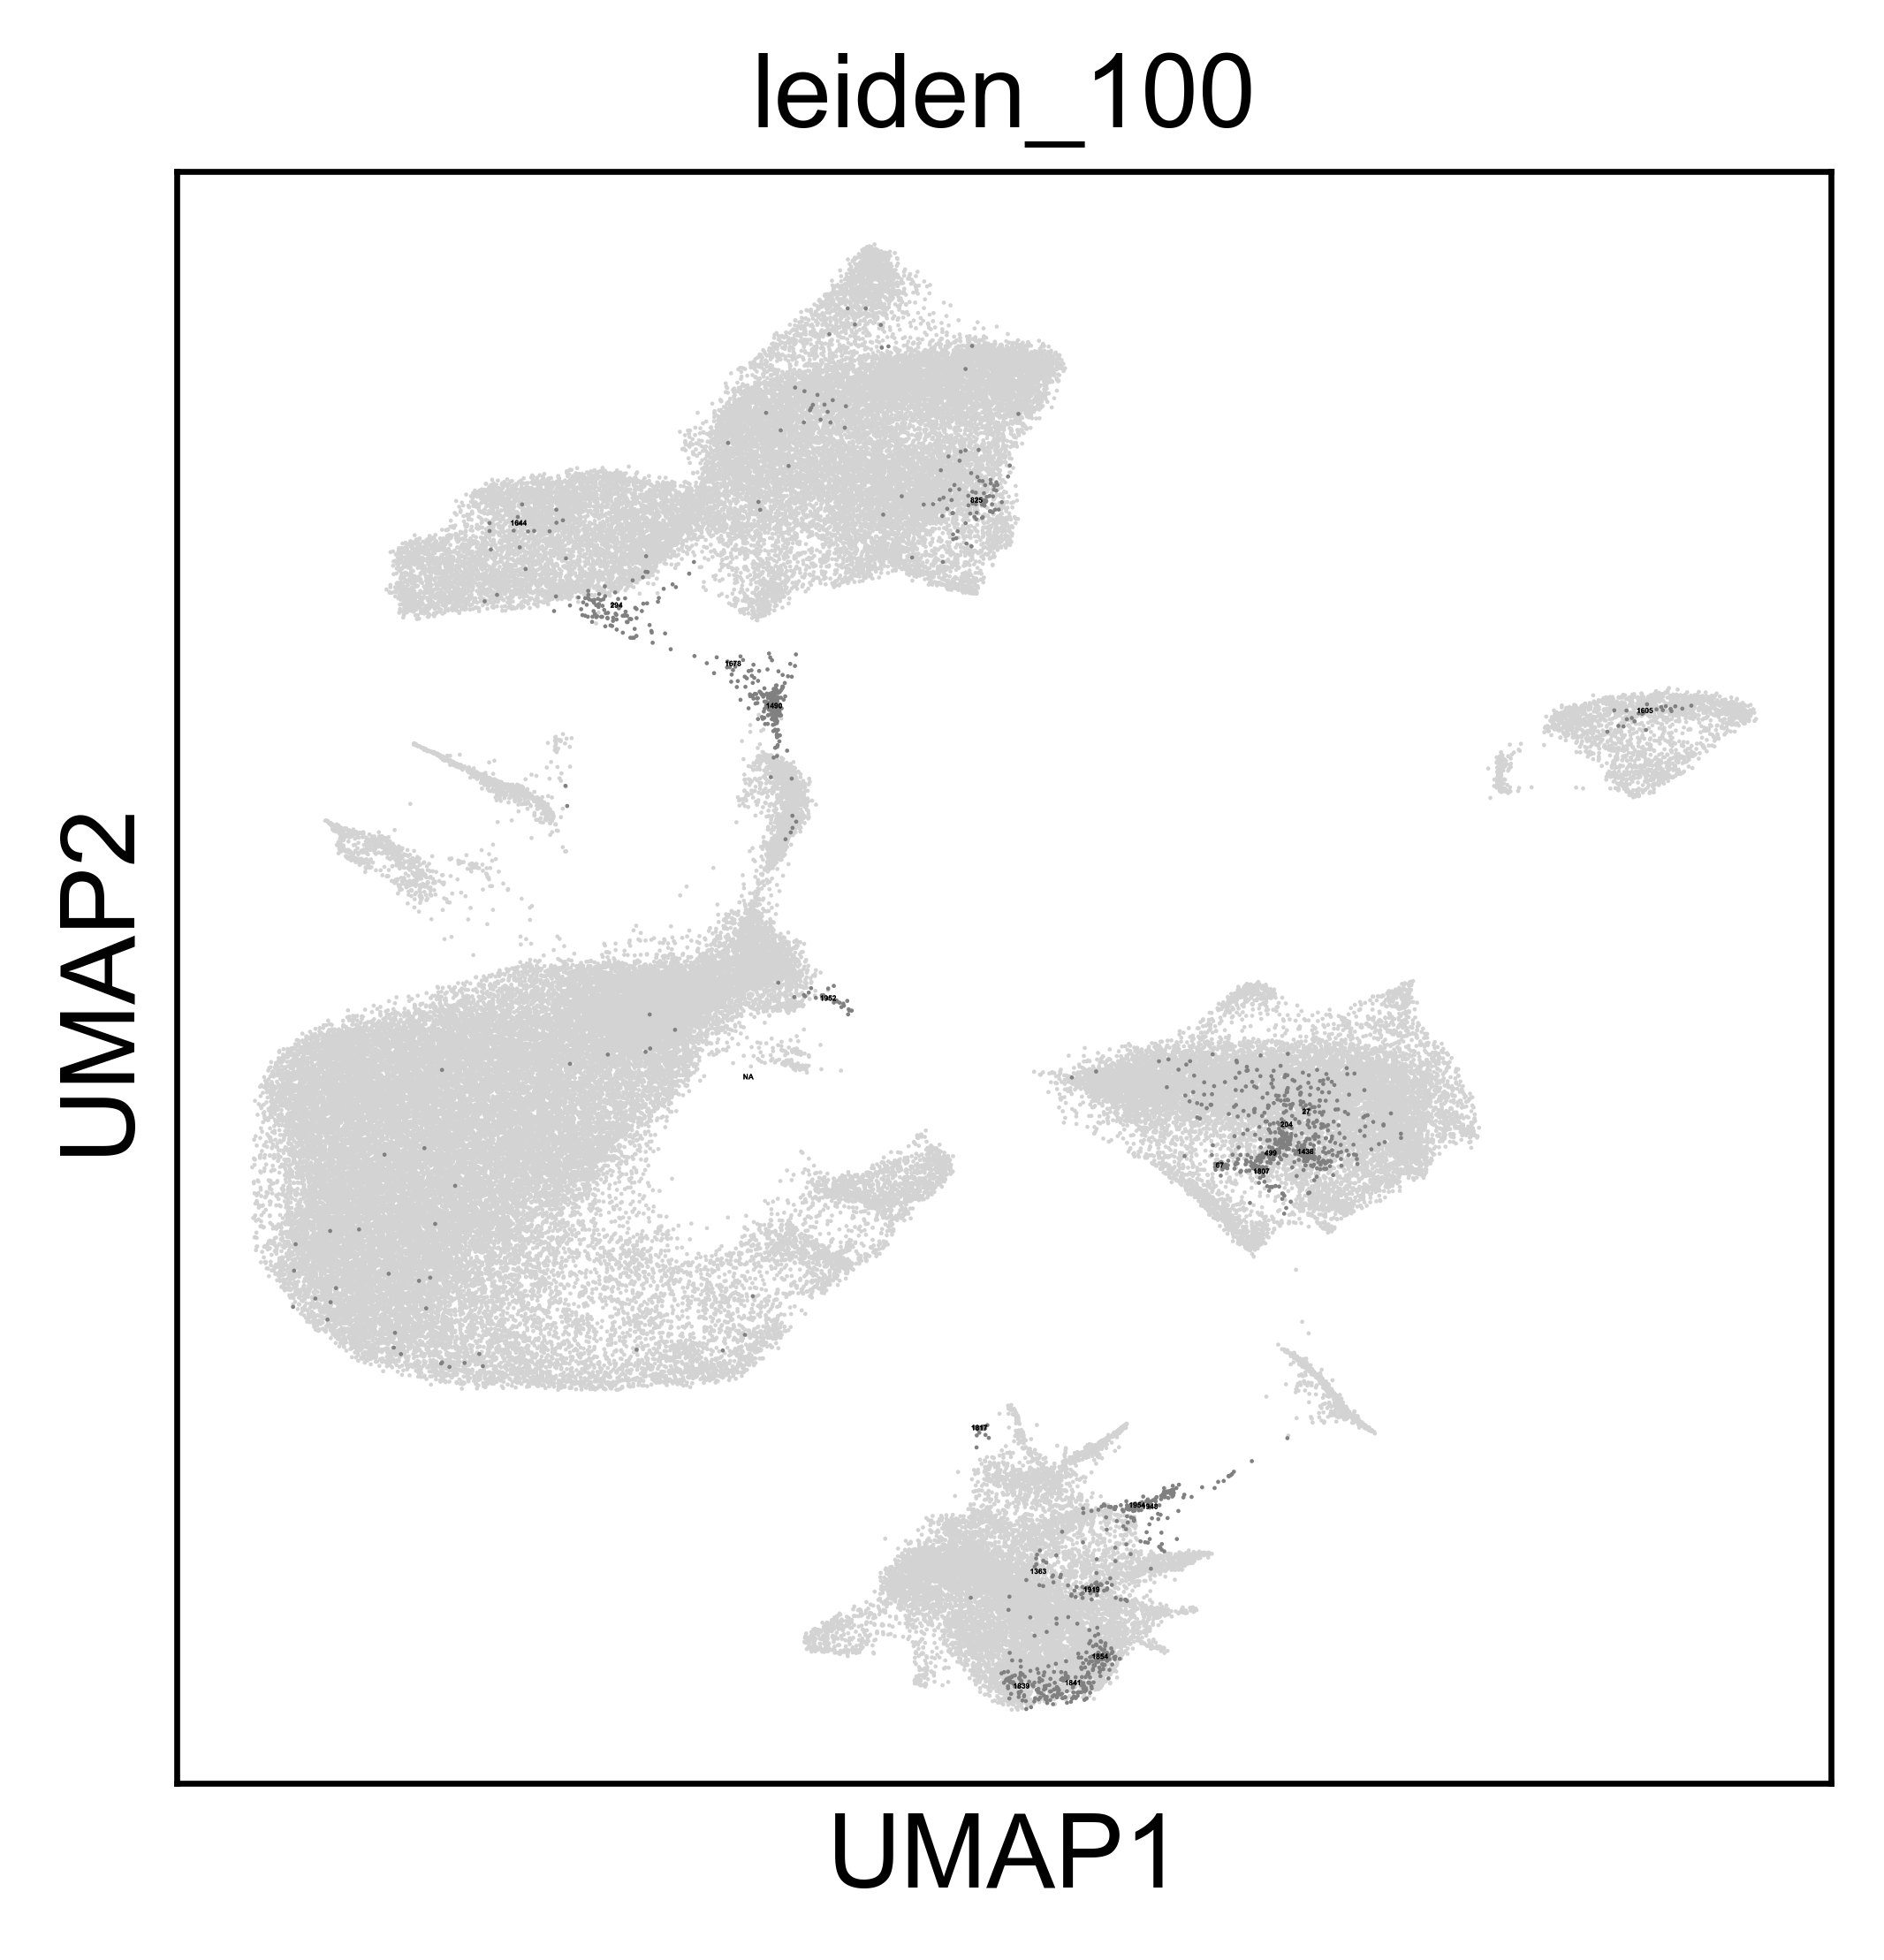

In [14]:
ax = sc.pl.umap(adata, color=["leiden_100"], groups = thetop, 
                legend_loc = "on data", legend_fontsize = 1, legend_fontoutline = False, 
                show = False)



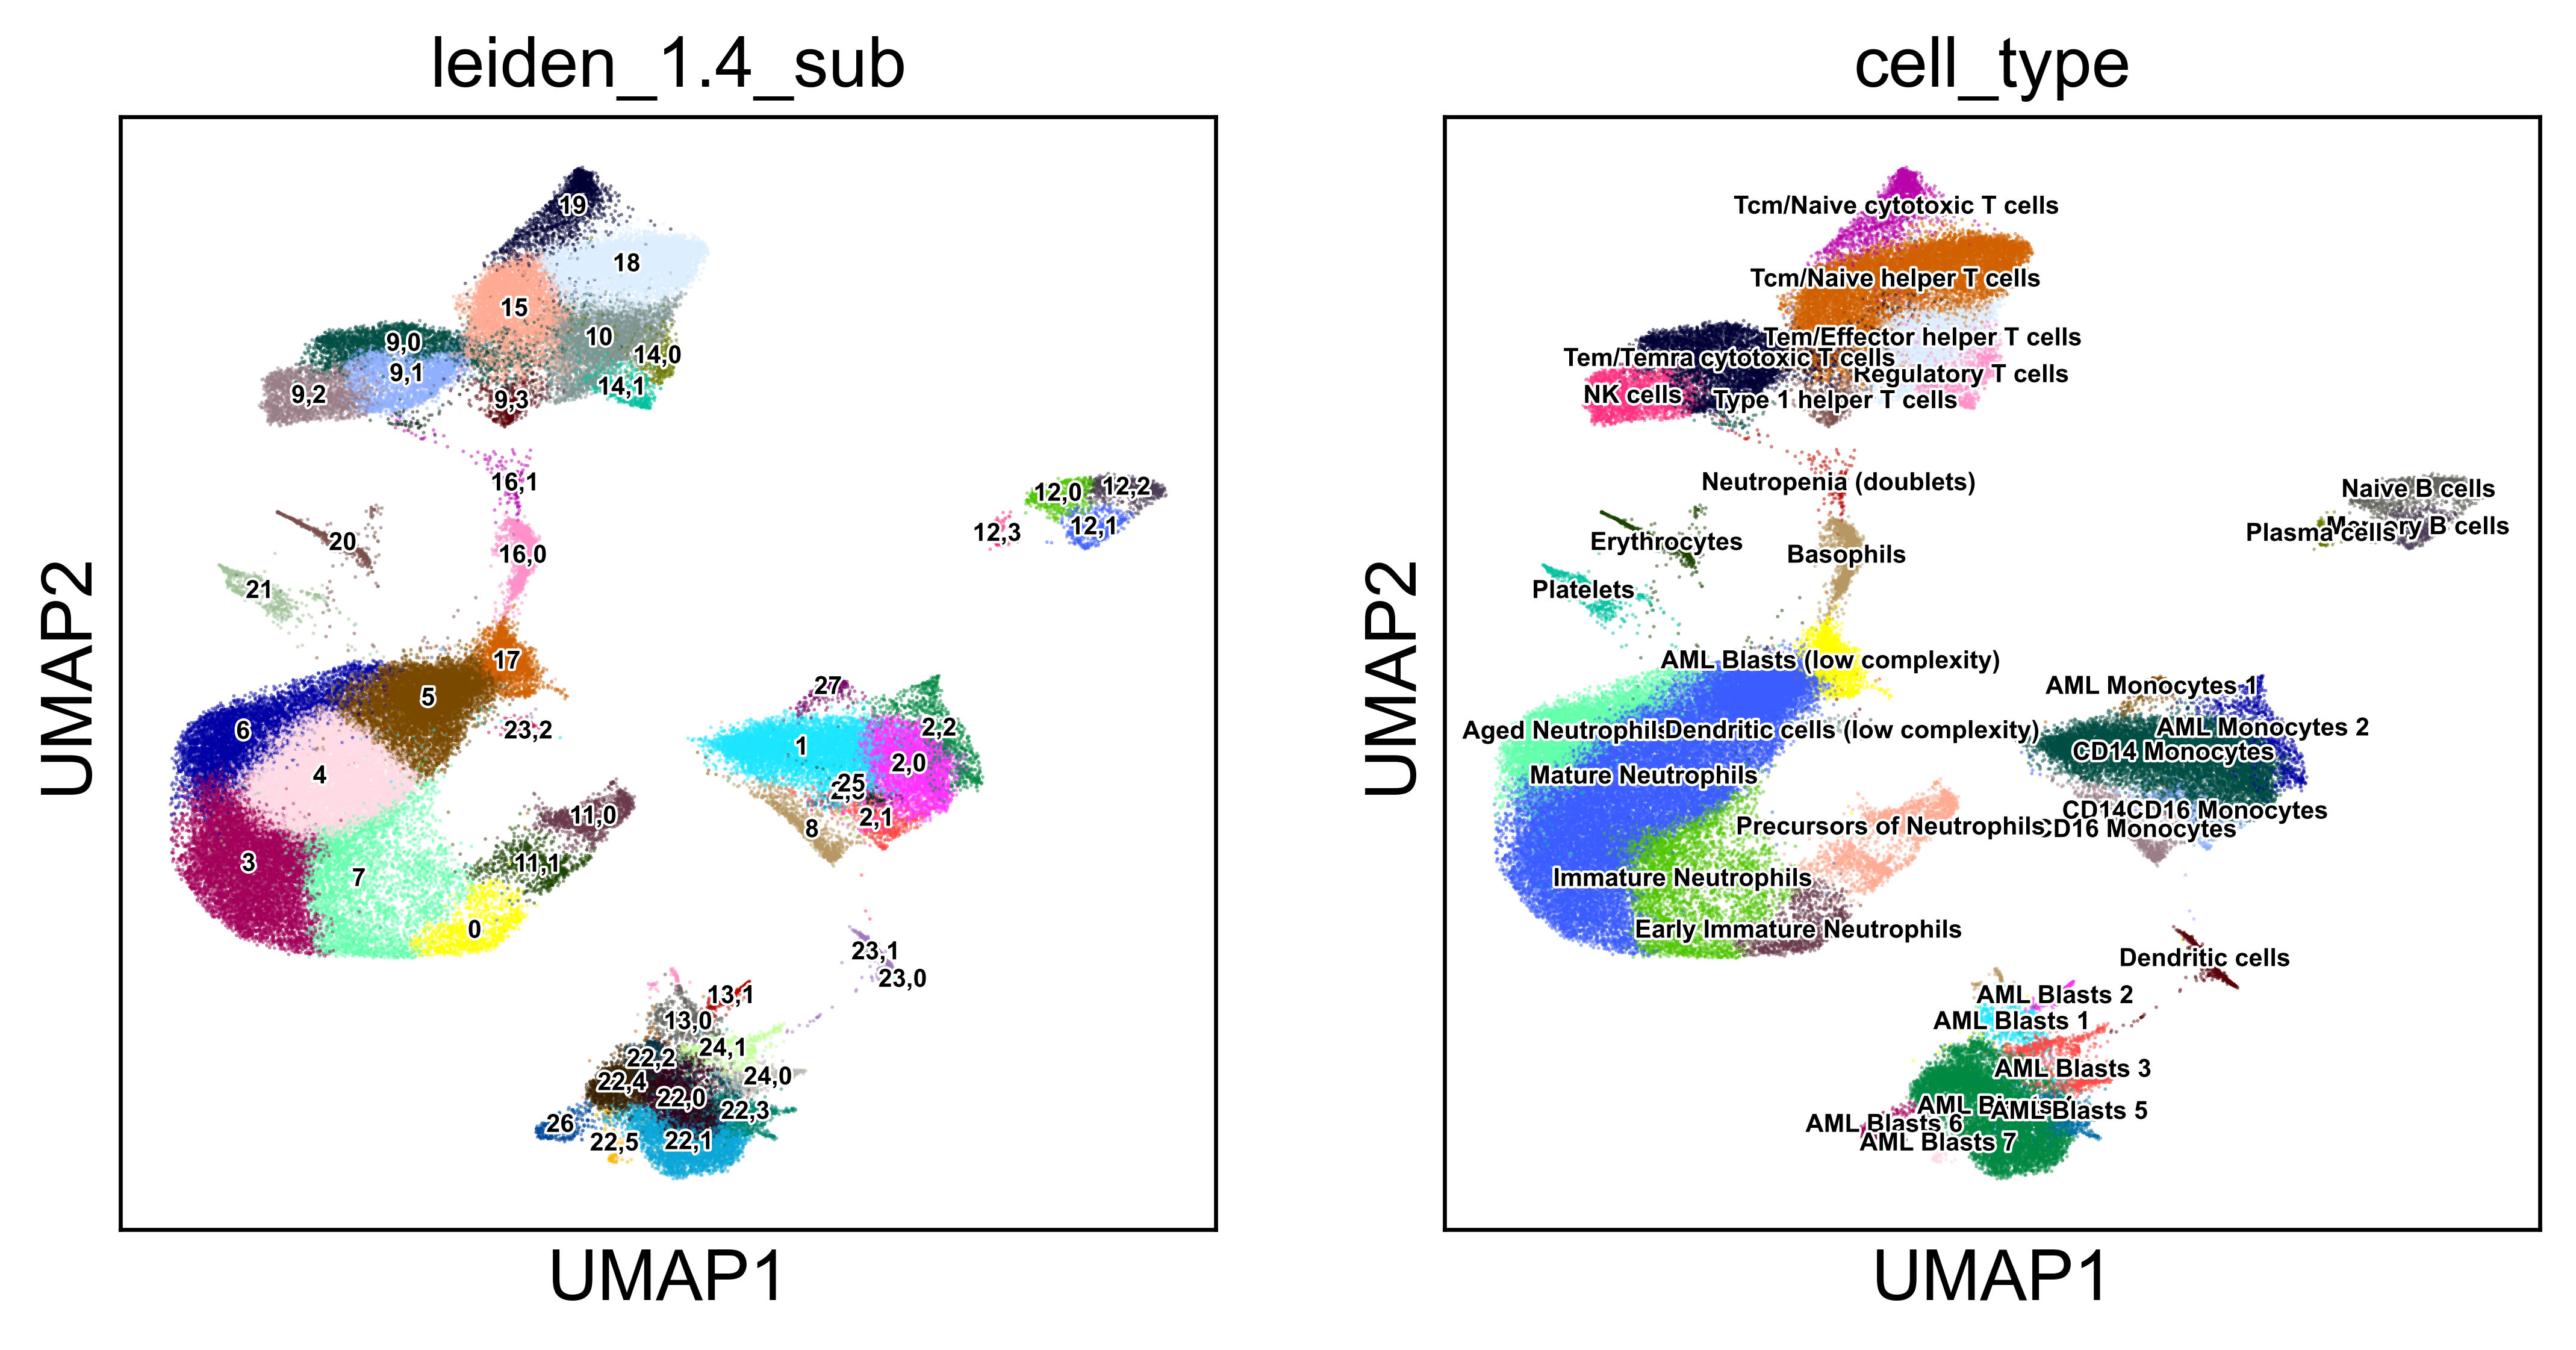

In [15]:
sc.pl.umap(adata, color = ["leiden_1.4_sub", "cell_type"], 
           alpha = 0.5, 
           wspace = 0.1,
           ncols = 3,
           s = 2, 
           legend_loc = "on data", legend_fontsize = 5, legend_fontoutline = True)

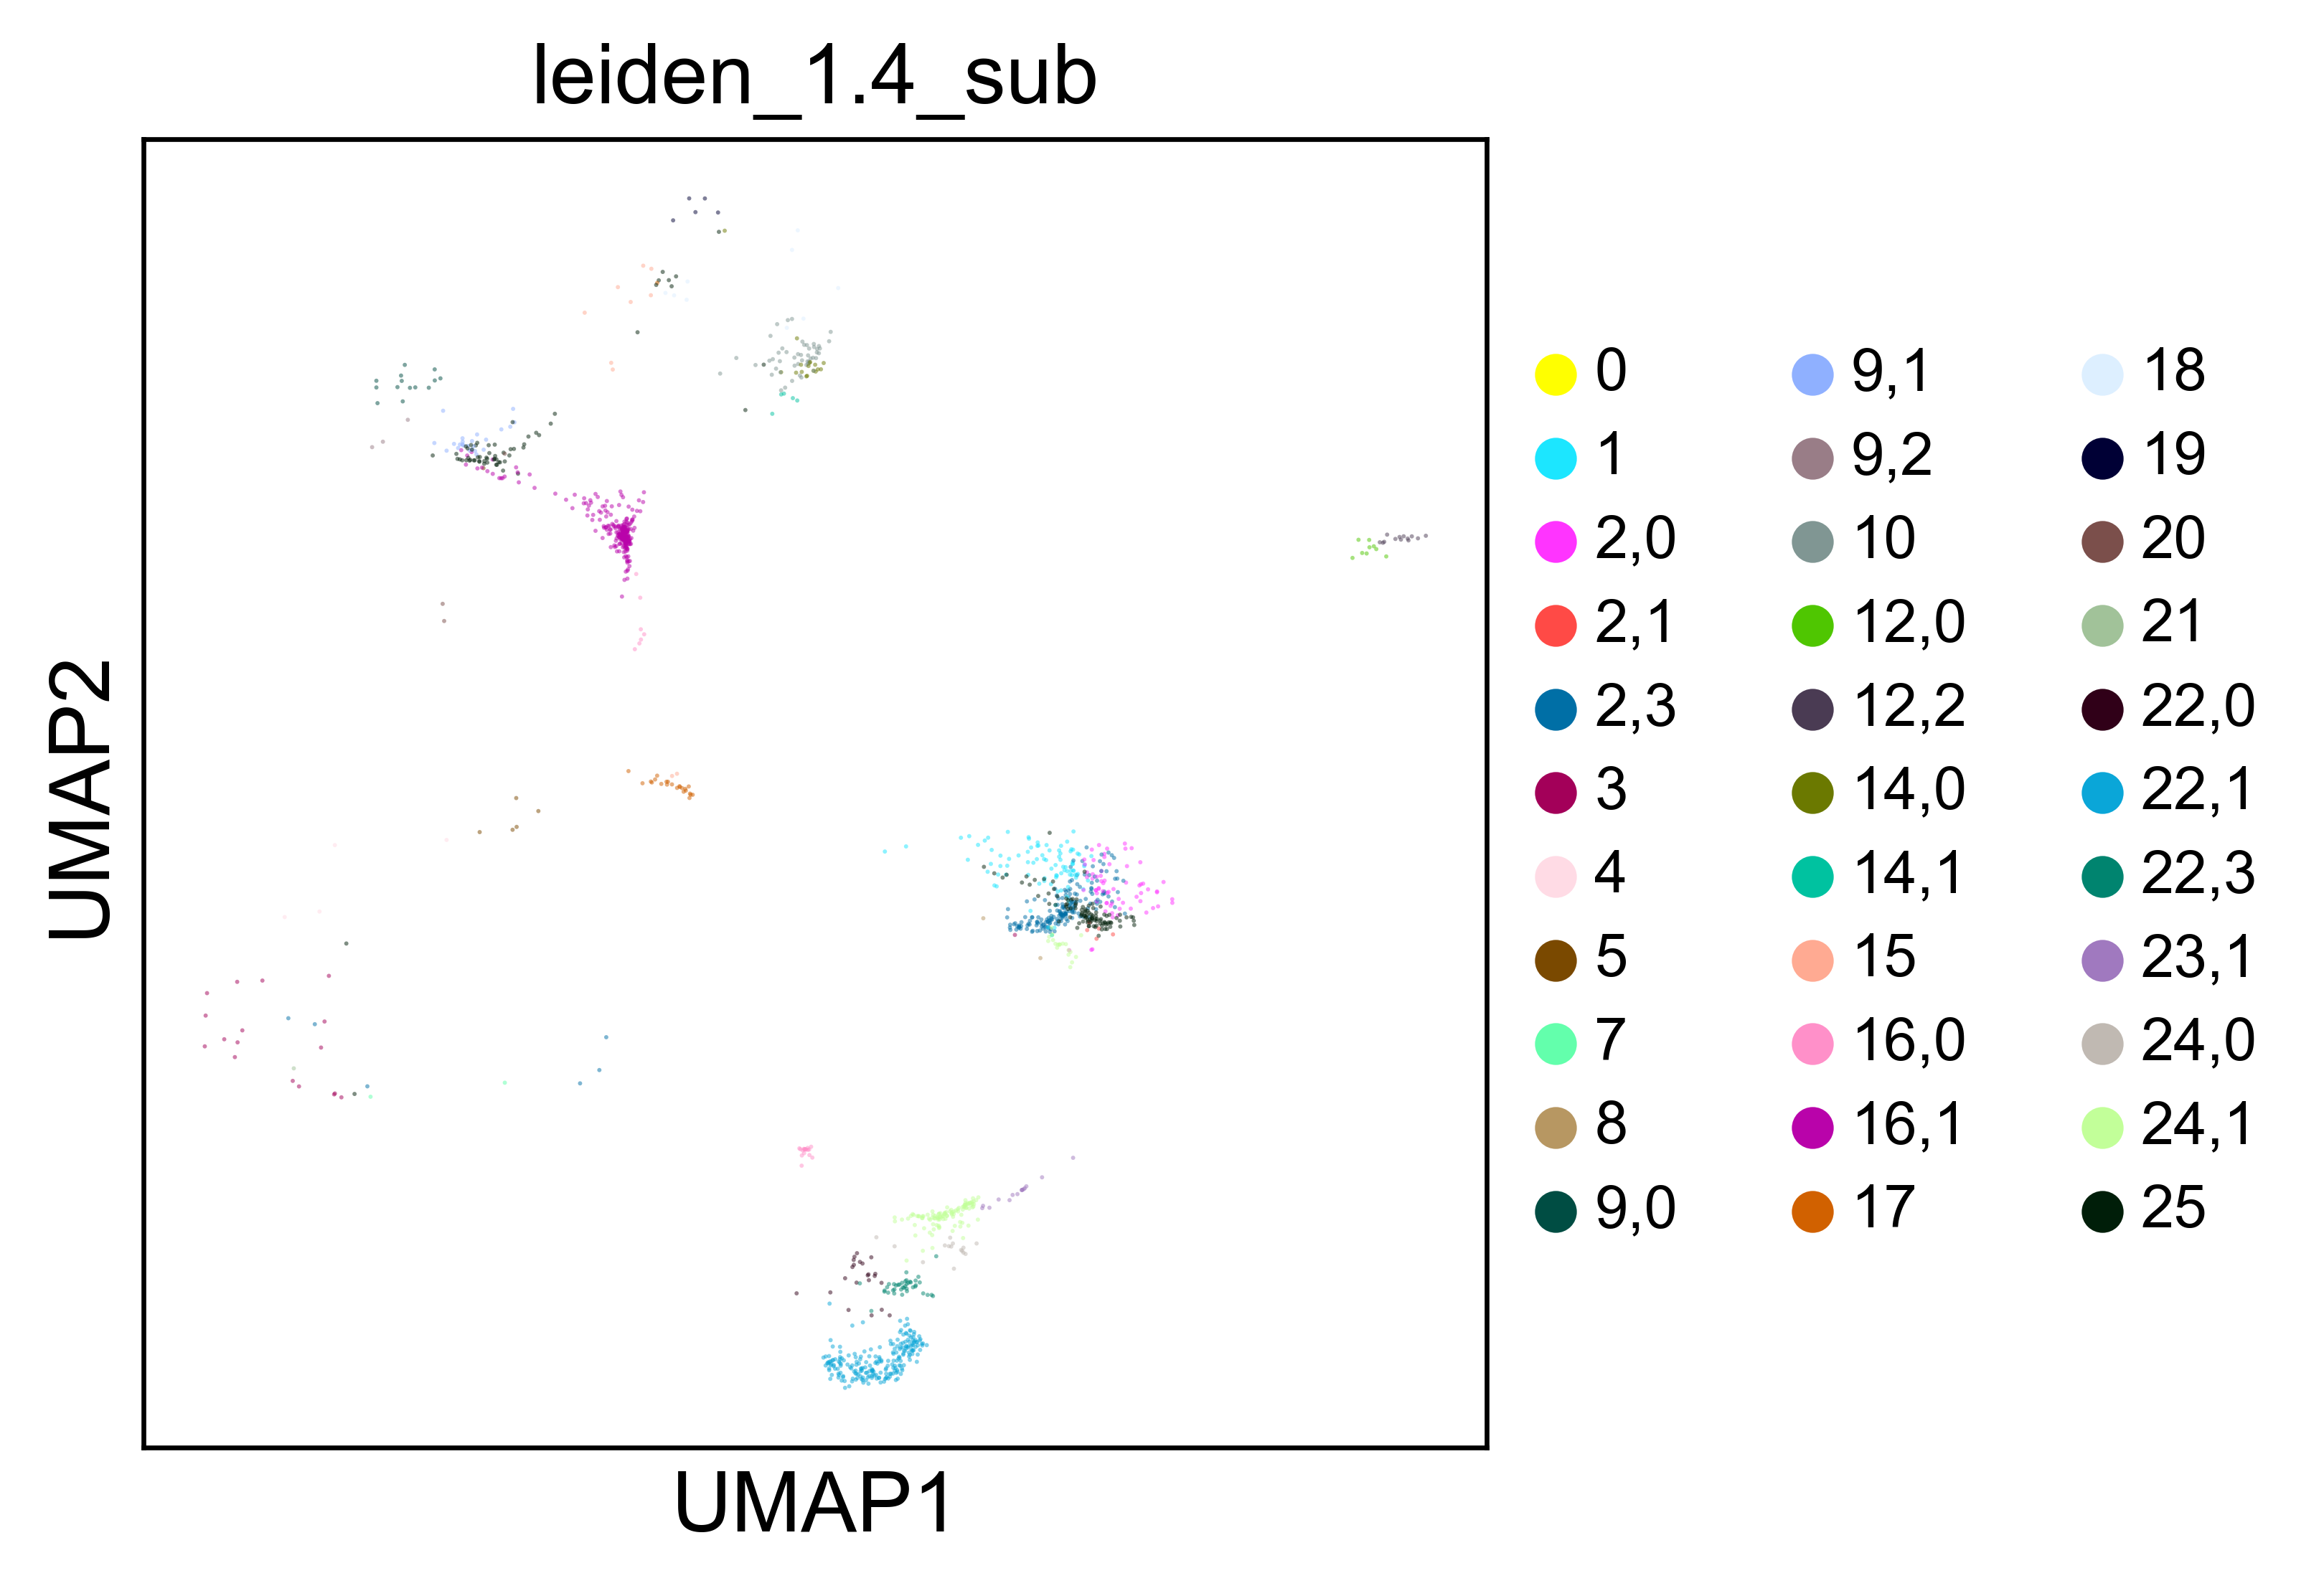

In [16]:
sc.pl.umap(adata[adata.obs["leiden_100"].isin(thetop)], color = ["leiden_1.4_sub"], 
           legend_fontsize = 10, legend_fontoutline = True, 
           alpha = 0.5, 
           wspace = 0.1,
           ncols = 3,
           s = 2)



## Inspect interactively  
Inspect whether clusters with high scores. convincingly look like doublets

This includes taking into consideration:
- large clusters are not expected to be doublets
- is there unique gene expression in these clusters? Then they are not doublets.
- can you tell from which real populations these clusters where made?

In [17]:
doubcl = ["1678", #near basophils/mast cells but don't express markers, mostly coming from one patient, separate clusters in umap
        "1490", #same situation as with 1678
        "294", #same situation as with 1678, scattered near t-cells
        "1817", #separate clusters in umap
        "1952", #separate clusters in umap, also lower complexity
        "1954", #shared expression of AML and dendritic
        "1948", #shared expression of AML and dendritic
        "67", #small separate cluster disguised in monocytes cluster
        "499", #small separate cluster disguised in monocytes cluster
        "204", #small separate cluster disguised in monocytes cluster
        "1438", #small separate cluster disguised in monocytes cluster
        "1807" #shared expression of AML and Monocytes 
           #'0', #scattered in X and Y
         ]


In [18]:
adata.obs[label].isin(doubcl).sum()

1009

In [19]:
# append "doublet_ufc"
adata.obs["doublet_ufc"] = adata.obs[label].isin(doubcl)
print(adata.obs["doublet_ufc"].unique())

[False  True]


In [20]:
# Number of cells that will be removed
sum(adata.obs["doublet_ufc"])

1009

## Selecting low complexity cells for removal

In [21]:
# append "doublet_ufc"
adata.obs["low_complexity"] = adata.obs["cell_type"].isin(["AML Blasts (low complexity)", "Dendritic cells (low complexity)"])
print(adata.obs["low_complexity"].unique())

# Number of low complexity cells that will be removed
sum(adata.obs["low_complexity"])


[False  True]


2217

In [22]:
# save the update obs dataframe
fname = 'backups/doublet_ufc_aml_lc_obs_info_%dx%d_%s'%(adata.obs.shape[0],adata.obs.shape[1],now())
print(fname)
save_df(adata.obs,fname)

backups/doublet_ufc_aml_lc_obs_info_95563x40_240729_21h57
